# Song Recommendation System Using Spotify Data

### Business Case:

I'm was hired by a production company that focuses on creating 8-bit covers of songs to help them figure out what they should cover next. They release all music on YouTube alongside an 8-bit-theme graphic, and their goal is to beat the YouTube algorithm. One of the strategies they need my help with is finding similar songs to covers that are already performing well. What other similar songs will their audience listen to? 

While there are many ways we can approach this problem, they want to find other suitable songs by the same artist or other similar songs based on sound characteristics. 

For that purpose, I will build a recommender system that uses Spotify data and returns a list of similar songs when given a singular song input.

In [1]:
#Import necessary libraries:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ast import literal_eval

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### EDA

I'm using a Kaggle dataset containing information about over 174,000 songs spanning from 1920 to today. 

In [2]:
#Read the main data file and save it as a data frame
df = pd.read_csv("data/data.csv")

#Check the shape of the dataframe 
df.shape

(174389, 19)

In [3]:
#Examine the first few rows of data
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
acousticness        174389 non-null float64
artists             174389 non-null object
danceability        174389 non-null float64
duration_ms         174389 non-null int64
energy              174389 non-null float64
explicit            174389 non-null int64
id                  174389 non-null object
instrumentalness    174389 non-null float64
key                 174389 non-null int64
liveness            174389 non-null float64
loudness            174389 non-null float64
mode                174389 non-null int64
name                174389 non-null object
popularity          174389 non-null int64
release_date        174389 non-null object
speechiness         174389 non-null float64
tempo               174389 non-null float64
valence             174389 non-null float64
year                174389 non-null int64
dtypes: float64(9), int64(6), object(4)
memory usage: 25.3+ MB


In [5]:
#Grabbing the hash value of the ID column and assigning it as the new unique song ID; need an numerical type for ID
#df['unique_id'] = df.id.map(hash)

In [6]:
#Check for null/missing values:
df.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

I'm still unsure if I'll use all features of this dataset. It's good to see that there are **no missing values** (Spotify is pretty generous with their data). For now, it seems like the **'id'** and **'release_date'** might be a **redundant** for my purposes. I plan on using the index of the DataFrame as its unique identifier and using just the year of release. 

In [7]:
#Check for duplicates in the dataset
df.duplicated().sum()

2159

In [8]:
#There are 2159 exact duplicates in the dataset (same values for all columns). Let's remove them:
df.drop_duplicates()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174379,0.795000,['Alessia Cara'],0.429,144720,0.211,0,45XnLMuqf3vRfskEAMUeCH,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174381,0.795000,['Alessia Cara'],0.429,144720,0.211,0,4pPFI9jsguIh3wC7Otoyy8,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174383,0.795000,['Alessia Cara'],0.429,144720,0.211,0,52YtxLVUyvtiGPxwwxayHZ,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174385,0.795000,['Alessia Cara'],0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021


In [9]:
# Though exact duplicates are now gone, we see there are still multiple entries for the same song by the same artist
# Let's remove all such instances:
df.drop_duplicates(subset=['artists', 'duration_ms', 'name'], keep='last')

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.009170,"['DJ Combo', 'Sander-7', 'Tony T']",0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.000060,6,0.1780,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.1860,2020
174385,0.795000,['Alessia Cara'],0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174386,0.806000,['Roger Fly'],0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.920000,4,0.1130,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.7140,2020
174387,0.920000,['Taylor Swift'],0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.000000,0,0.1130,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.3200,2021


I **removed a total of 7,176 entries**. There's still a possibility that some duplicates remain, perhaps different versions of a song (e.g., radio version vs. album versions). At the moment, that's not a big concern, so I'll continue with the analysis.

In [10]:
#Display some sample statistics and look for outliers 

desc_df = df.describe()

desc_df

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


Everything looks fine, though I will need to scale some of these columns when constructing my recommendation system. There are some interesting observations, such as 1.48 minutes being the standard deviation for song duration. I'm curious to see how duration has changed over the years. Duration is also an important characteristic to keep in mind when choosing songs to cover as YouTube recommends content that facilitates longer viewing sessions.

In [11]:
#Reformatting the "Artists" column to display the artists without any special characters 
df['artists'] = df['artists'].map(lambda x: literal_eval(x))
df['artists'] = df['artists'].map(lambda x: x[0])

In [12]:
df

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,Mamie Smith,0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,Screamin' Jay Hawkins,0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,Mamie Smith,0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,Oscar Velazquez,0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,Mixe,0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.009170,DJ Combo,0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.000060,6,0.1780,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.1860,2020
174385,0.795000,Alessia Cara,0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174386,0.806000,Roger Fly,0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.920000,4,0.1130,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.7140,2020
174387,0.920000,Taylor Swift,0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.000000,0,0.1130,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.3200,2021


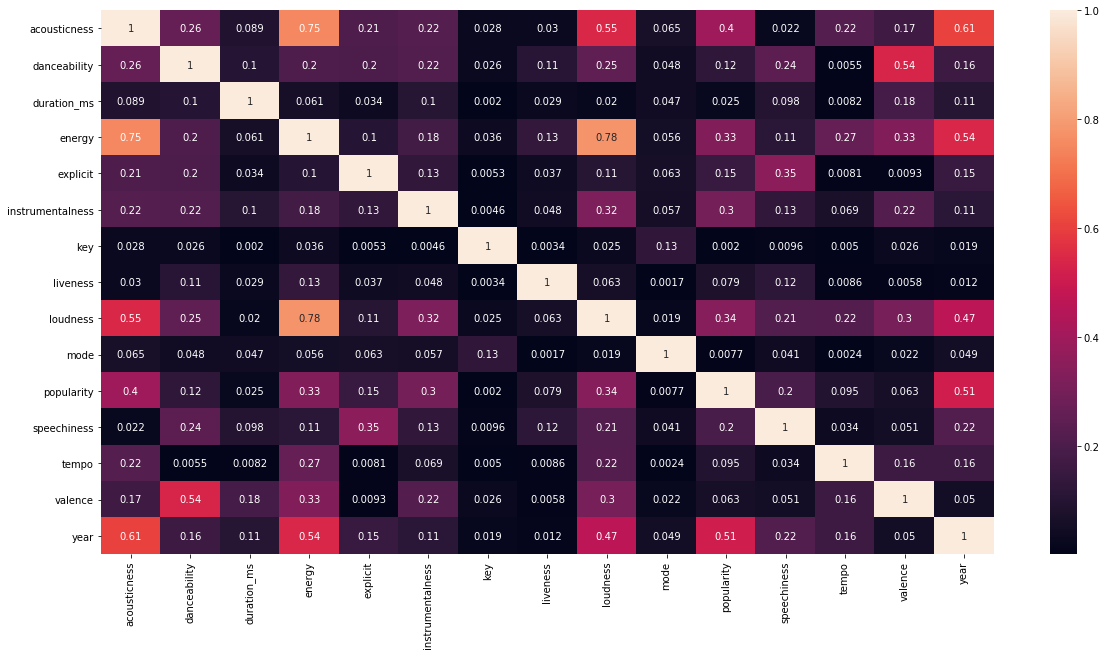

In [13]:
#Explore the correlation between different features 
corr = df.corr().abs()
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

No major surprises here. Most of the correlations make total sense, e.g., one would expect 'energy' and 'loudness' to have a strong positive correlation.

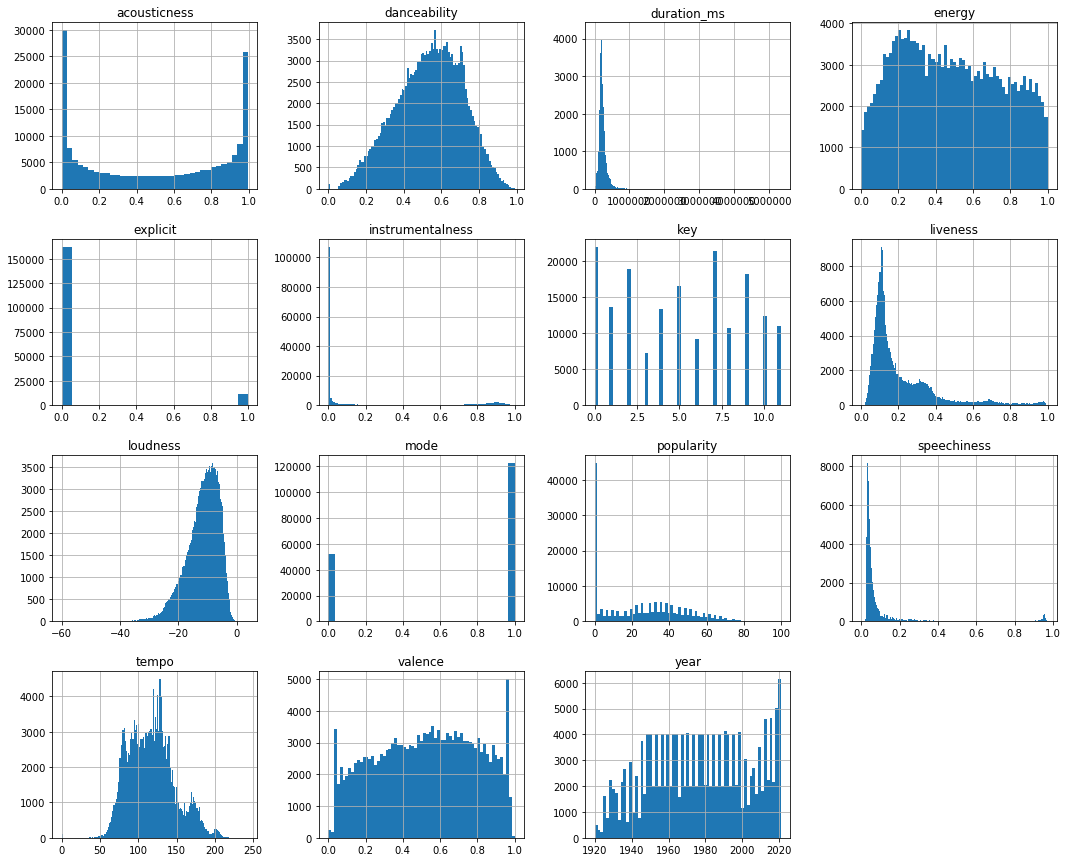

In [14]:
#Let's explore the distribution of each feature by plotting a histogram for each:
df.hist(figsize=(18,15), bins='auto');

A lot of the features do not follow a normal distribution. Except 'speechiness', no other feature appears to have concerning outliers. For now, I won't remove any outliers based on these distributions.

##### Let's explore more in depth! 

In [15]:
#Exploring how many songs there are from each year
print(df.year.nunique())

df.year.value_counts()

102


2020    4294
2018    2714
2013    2622
2016    2349
2019    2329
        ... 
1925     279
1924     236
1923     185
1921     156
1922     121
Name: year, Length: 102, dtype: int64

(array([1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 <a list of 8 Text xticklabel objects>)

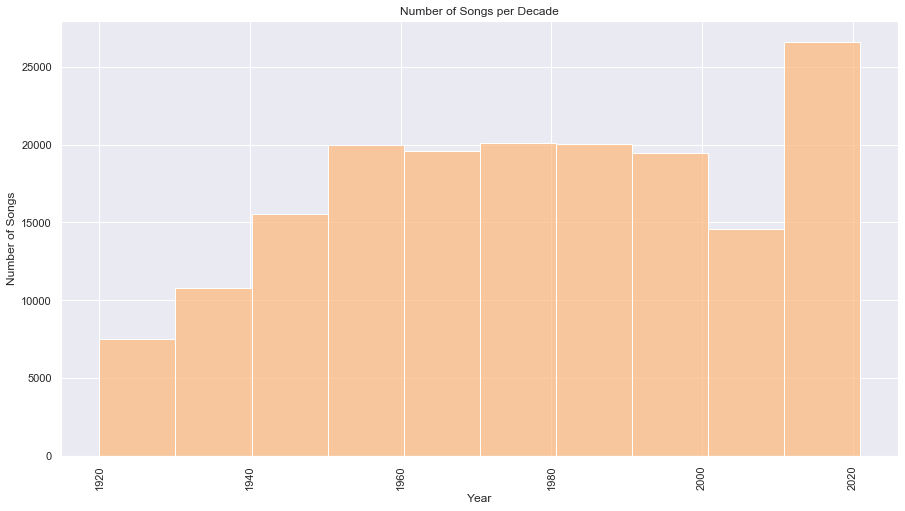

In [74]:
#Using a histogram to explore the song distribution by decades
sns.set(rc={'figure.figsize':(15,8)}, palette='magma_r')
axis = sns.histplot(df.year, bins=10)
axis.set_title('Number of Songs per Decade')
axis.set_ylabel('Number of Songs')
axis.set_xlabel('Year')
plt.xticks(rotation = 90)

Next, I'm going to explore how various song properties have changed over the years. 

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

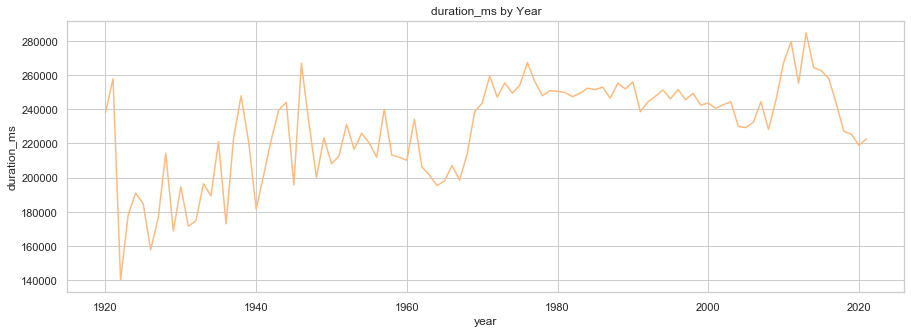

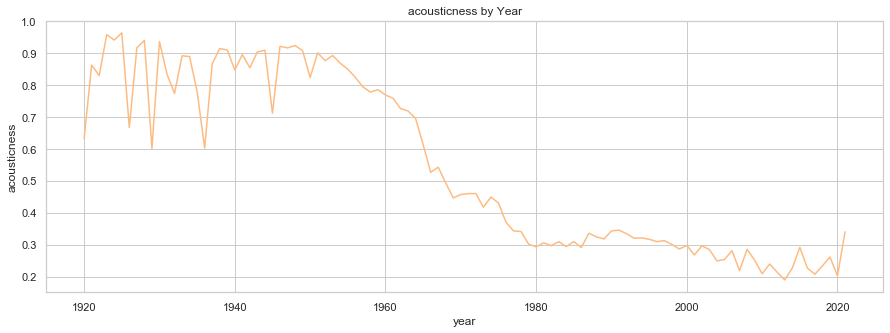

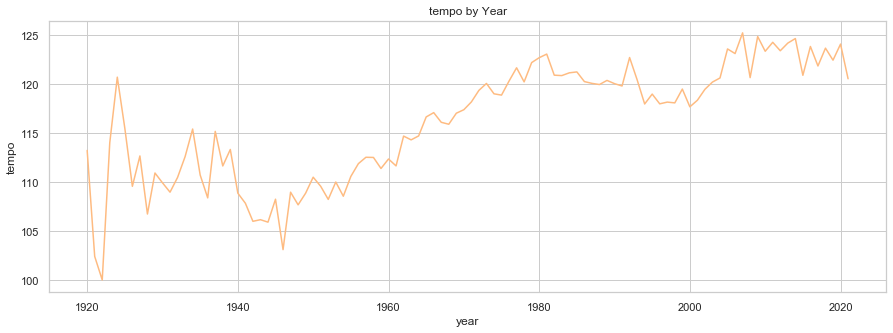

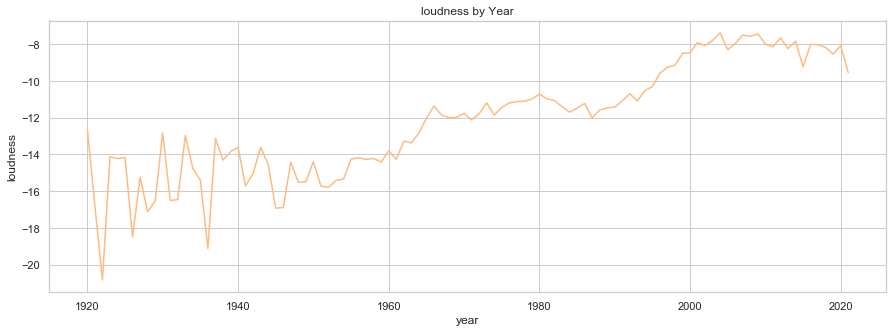

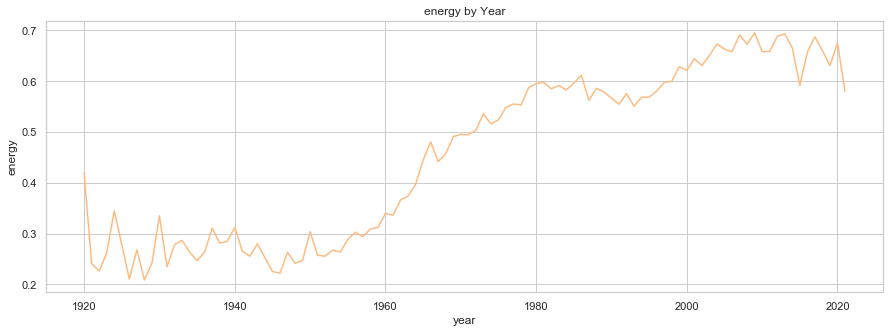

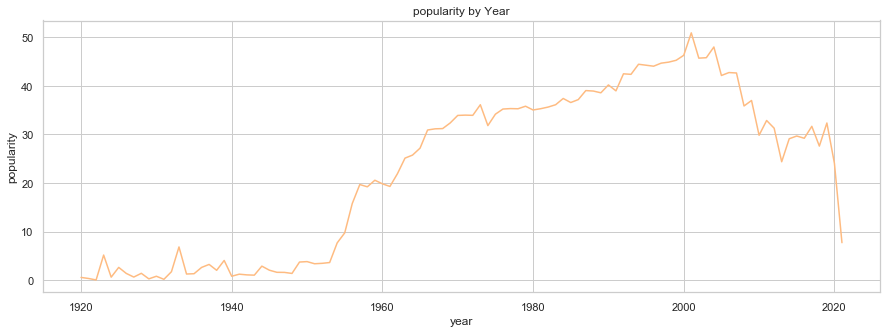

In [18]:
#Create a visualization for each of the following categories and its development through the years
categories = ['duration_ms', 'acousticness', 'tempo', 'loudness', 'energy', 'popularity']

for col in categories:
    y = df.groupby('year')[col].mean()
    x = y.index
    plt.figure(figsize=(15, 5))
    sns.set_style("whitegrid")
    plt.title(f"{col} by Year")
    sns.lineplot(x, y)

**Findings:** 

Songs in recent years are getting shorter, approaching the average duration for music from the 70s.

More recent music is faster and more energetic. Acousticness has become less prevalent after the 60s, and again after the 90s. That trend seems to be changing in 2021.

The early 2000s seems like one of the most popular decades on Spotify.

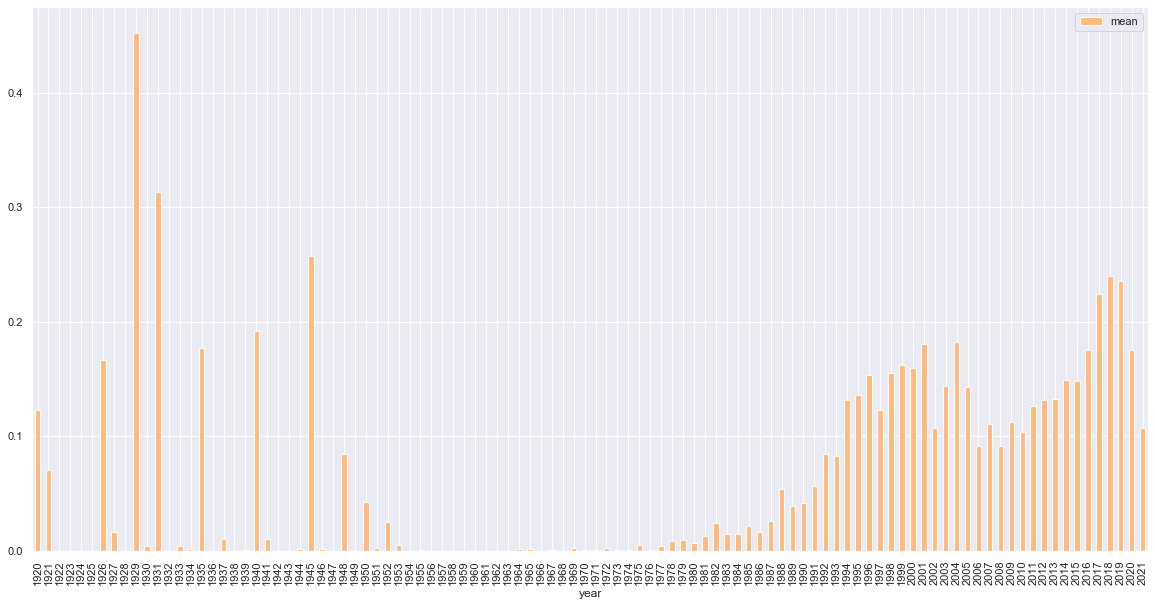

In [75]:
#Let's see how cursing has changed over the years
explicit = df.groupby('year')['explicit'].mean()
explicit = explicit.reset_index()
explicit.columns = ['year', 'mean']
explicit.plot.bar(x='year', y='mean', figsize=(20,10))

Some surprising explicit content for songs before 1950, but we are less interested in the decades before the 80s, so I'm not going to dig deeper. As expected, with the rising dominance of hip-hop on streaming in the 2010s, explicit content is rising.

Next, let's explore which individual songs are currently most popular:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

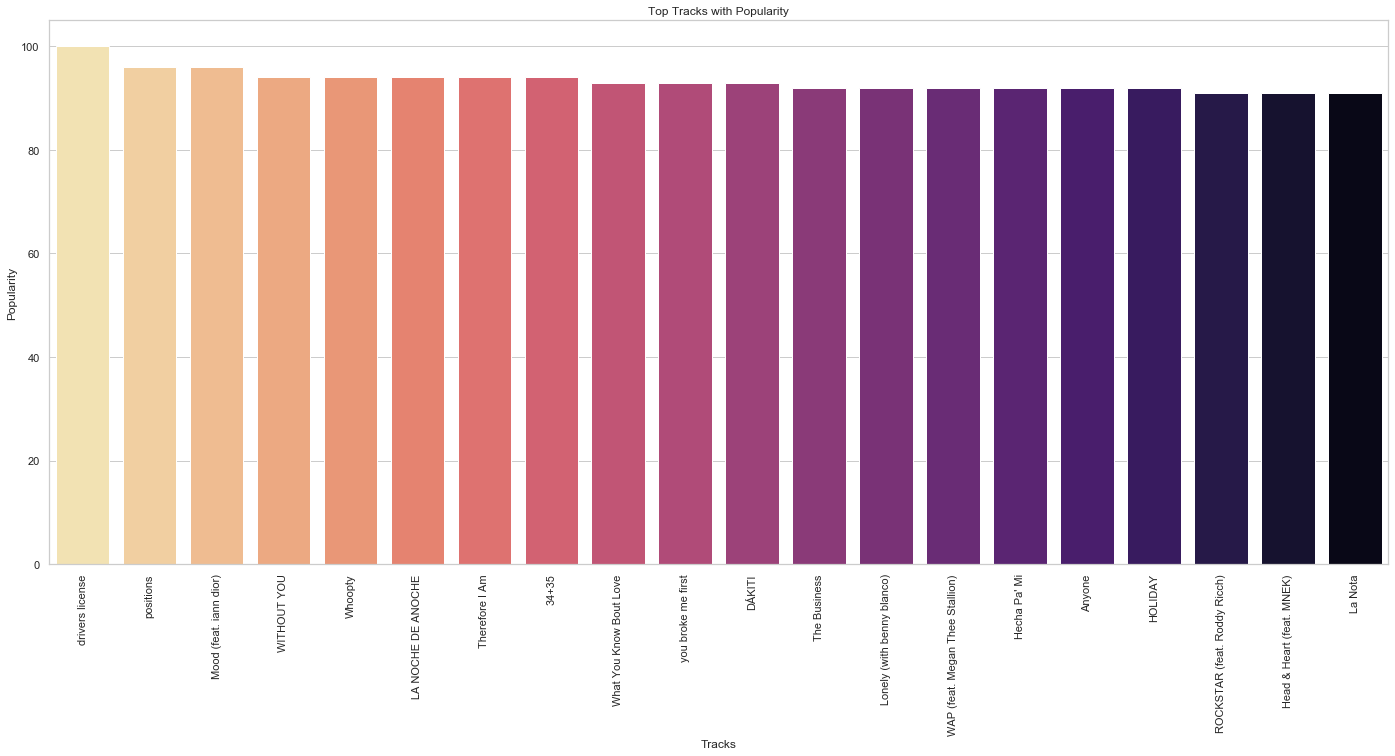

In [20]:
plt.figure(figsize=(24, 10))
sns.set(style="whitegrid")
x = df.groupby("name")["popularity"].mean().sort_values(ascending=False).head(20)
axis = sns.barplot(x.index, x, palette='magma_r')
axis.set_title('Top Tracks with Popularity')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90)

In [21]:
print('25 Most Popular Songs on Spotify!')
df[['name','artists','release_date','popularity']].sort_values(by='popularity',ascending=False).head(25)

25 Most Popular Songs on Spotify!


,name,artists,release_date,popularity
20062,drivers license,Olivia Rodrigo,2021-01-08,100
19862,Mood (feat. iann dior),24kGoldn,2020-07-24,96
19866,positions,Ariana Grande,2020-10-30,96
19886,DÁKITI,Bad Bunny,2020-10-30,95
19976,BICHOTA,KAROL G,2020-10-23,95
19868,34+35,Ariana Grande,2020-10-30,94
19870,Whoopty,CJ,2020-08-20,94
19872,WITHOUT YOU,The Kid LAROI,2020-11-06,94
19876,Therefore I Am,Billie Eilish,2020-11-12,94
19928,LA NOCHE DE ANOCHE,Bad Bunny,2020-11-27,94


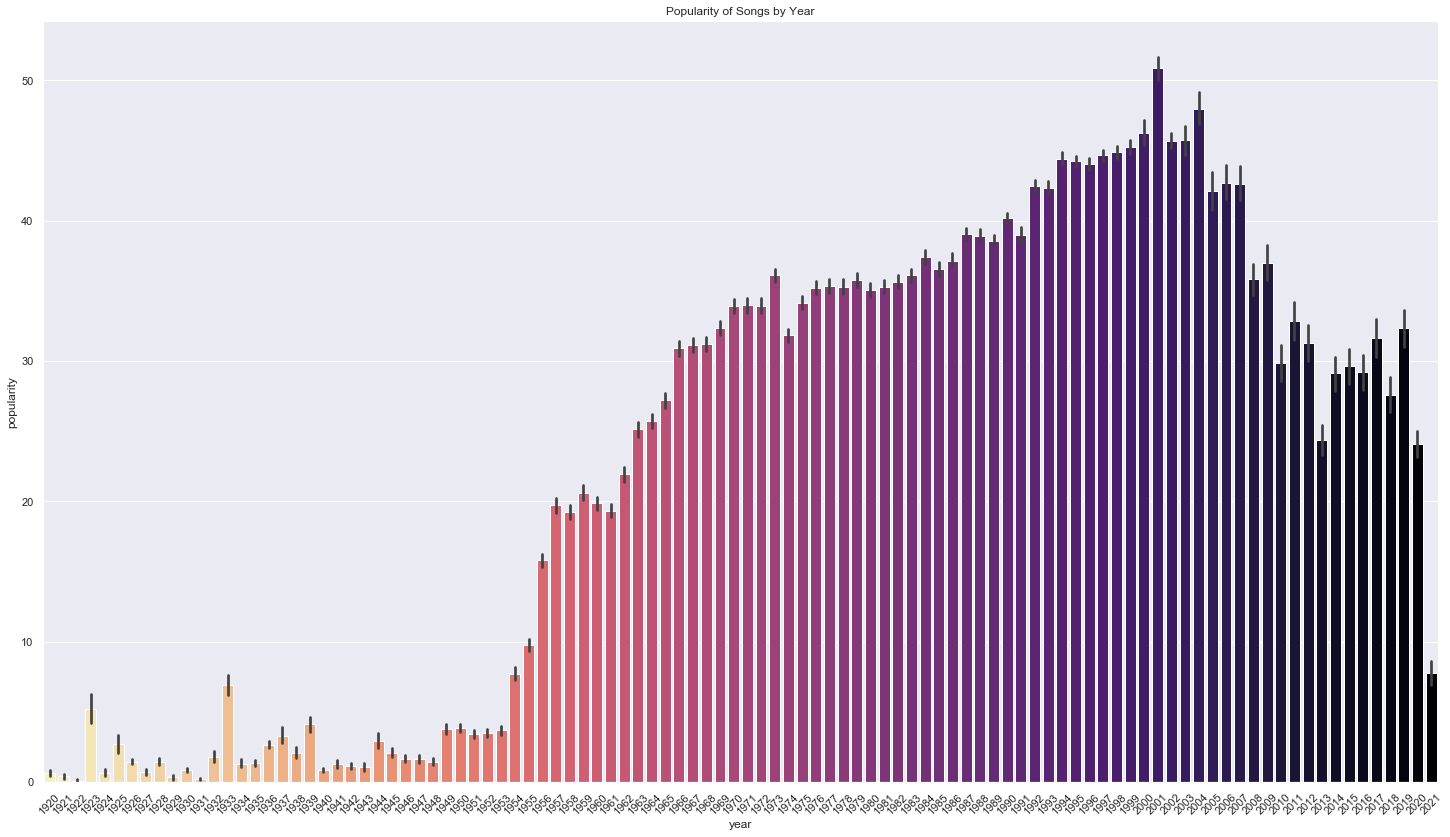

In [76]:
#Taking a closer look at what the line graph above showed us about popularity
plt.figure(figsize=(25,14))
plt.xlabel('year')
plt.ylabel('popularity')
plt.xticks(rotation=45)
plt.title('Popularity of Songs by Year')
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
sns.barplot(x='year',y='popularity',data=df.sort_values(by='year',ascending=False), palette='magma_r')
plt.show()

It appears that songs from 1999 and 2000, and 2003 have amassed the highest popularity. Perhaps, it's fitting to pick a song from that era to get recommendations for.

Let's look at overall popularity by artists:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

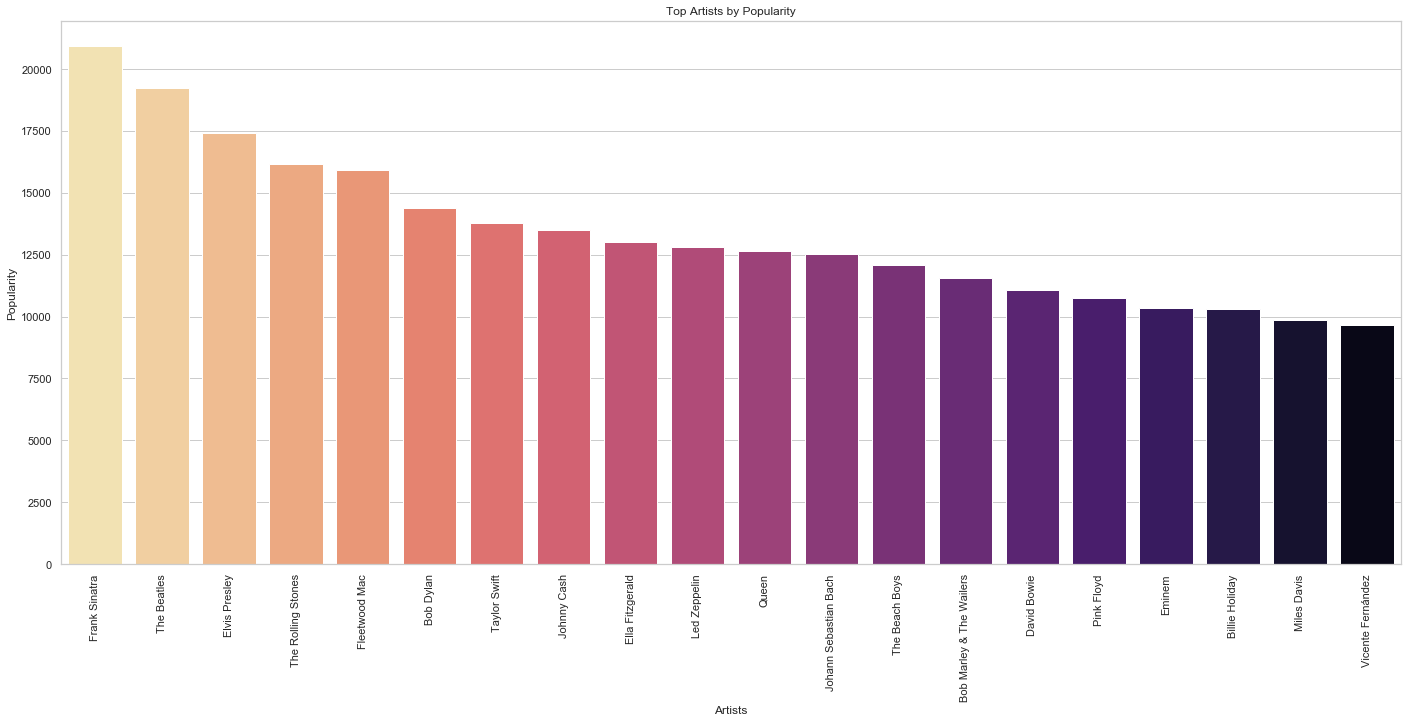

In [77]:
plt.figure(figsize=(24, 10))
sns.set(style="whitegrid")
x = df.groupby("artists")["popularity"].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x.index, x, palette='magma_r')
ax.set_title('Top Artists by Popularity')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

### Data Preparation 

As the graphs above prove, songs released after 1980 are the most popular among current listeners. Moreover, they are also more likely to gain traction when covered on YouTube.

In [24]:
# Slicing the data by savings all songs released after 1980 as a new DataFrame 
songs = df[df['year'] > 1980]
print(songs.shape)
songs.head()

(80733, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
9071,0.394,Gerry & The Pacemakers,0.484,160187,0.265,0,6catF1lDhNTjjGa2GxRQNN,0.000000,0,0.149,-11.101,1,You'll Never Walk Alone - Mono; 2002 Remaster,55,2008-02-11,0.0322,113.564,0.285,2008
9081,0.255,Gerry & The Pacemakers,0.405,141987,0.365,0,4aSw1QJIMwYSoDEgzgdCJL,0.000005,6,0.163,-10.226,0,Ferry Cross the Mersey - Mono; 2002 Remaster,39,2008-02-11,0.0289,104.536,0.588,2008
9085,0.406,Gerry & The Pacemakers,0.477,157093,0.352,0,0ZMMtH875IR2TfkyC4PolD,0.000000,1,0.122,-14.165,1,Don't Let the Sun Catch You Crying (Main) - Mono,34,2008-02-11,0.0300,106.773,0.478,2008
9087,0.887,Frank Sinatra,0.319,187333,0.201,0,1hx7X9cMXHWJjknb9O6Ava,0.000000,7,0.904,-17.796,1,The September Of My Years - Live At The Sands ...,27,2018-05-04,0.0623,117.153,0.239,2018
9091,0.938,Frank Sinatra,0.269,236800,0.129,0,19oquvXf3bc65GSqtPYA5S,0.000005,7,0.683,-18.168,0,It Was A Very Good Year - Live At The Sands Ho...,26,2018-05-04,0.0576,82.332,0.160,2018


Since the Spotify ID is in a str format, I'll use each row's index as the unique ID for recommendations. For that purpose, I'll reset the index to ensure my functions don't run into "out of bounds" errors. 

In [25]:
#Resetting the index for the new DataFrame

songs.reset_index(drop=True, inplace=True)

In [26]:
#Dropping columns I won't need 
songs = songs.drop(columns=['id', 'release_date'])

Since one of my recommendation techniques will be based on sound similarity, I will scale the sound parameters and reorder the DataFrame to display the metadata for each song first and the features pertaining to sound last.

In [27]:
sound_params = songs[['acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']]

metadata = songs.drop(['acousticness', 'danceability','energy', 'instrumentalness', 'key', 
                       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'], axis = 1)

In [28]:
sound_params.head(10)

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.394,0.484,0.265,0.000000,0,0.1490,-11.101,1,0.0322,113.564,0.285
1,0.255,0.405,0.365,0.000005,6,0.1630,-10.226,0,0.0289,104.536,0.588
2,0.406,0.477,0.352,0.000000,1,0.1220,-14.165,1,0.0300,106.773,0.478
3,0.887,0.319,0.201,0.000000,7,0.9040,-17.796,1,0.0623,117.153,0.239
4,0.938,0.269,0.129,0.000005,7,0.6830,-18.168,0,0.0576,82.332,0.160
5,0.360,0.617,0.711,0.000002,9,0.0841,-6.433,1,0.0297,142.266,0.963
6,0.881,0.644,0.212,0.000022,11,0.7980,-14.118,1,0.0347,117.072,0.441
7,0.955,0.627,0.184,0.000162,1,0.0986,-15.533,1,0.0450,115.864,0.299
8,0.888,0.581,0.331,0.000015,6,0.1470,-14.087,1,0.2430,88.303,0.642
9,0.930,0.442,0.399,0.000499,6,0.9120,-12.661,1,0.0780,121.662,0.554


In [29]:
#Scale the sound-specific features and organize them in a new DataFrame
scaler = MinMaxScaler()

sound_features = pd.DataFrame()

for col in sound_params.columns:    
    
    sound_features[col] = scaler.fit_transform(sound_params[col].values.reshape(-1,1)).ravel() 

In [30]:
sound_features.head(3)

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.395582,0.489879,0.265,0.000000,0.000000,0.149,0.771679,1.0,0.033472,0.505995,0.285
1,0.256024,0.409919,0.365,0.000005,0.545455,0.163,0.785488,0.0,0.030042,0.465770,0.588
2,0.407631,0.482794,0.352,0.000000,0.090909,0.122,0.723326,1.0,0.031185,0.475737,0.478


In [31]:
#Combine the songs metadata with the sound features in a new DataFrame
mdf = metadata.join(sound_features)

I have a well-formatted DataFrame with scaled sound properties and reformatted artist names. It's time to use it to recommend some songs.

In [32]:
mdf.tail(3)

,artists,duration_ms,explicit,name,popularity,year,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
80730,Roger Fly,218147,0,Together,0,2020,0.809237,0.679150,0.589,0.920,0.363636,0.113,0.751290,0.0,0.029314,0.481463,0.714
80731,Taylor Swift,244000,1,champagne problems,69,2021,0.923695,0.467611,0.240,0.000,0.000000,0.113,0.756277,1.0,0.039189,0.763328,0.320
80732,Roger Fly,197710,0,Improvisations,0,2020,0.239960,0.685223,0.460,0.891,0.636364,0.215,0.753752,1.0,0.026819,0.499953,0.747


In [33]:
# HELPER FUNCTIONS


def get_index_from_name(name):
    '''
    This function returns the index of the row when given a song name
    '''
    return mdf[mdf["name"]==name].index.tolist()[0]

# all_songs = list(mdf.name.values)

# def get_id_from_partial_name(partial):
#     for name in all_songs:
#         if partial in name:
#             print(name,all_songs.index(name))

            
# def reformat_artists(x):
#     if isinstance(x, list):
#         return [str.lower(i.replace(" ", "")) for i in x]
#     else:
       
#         if isinstance(x, str):
#             return str.lower(x.replace(" ", ""))
#         else:
#             return '' 

### Objective: Recommend songs similar to Missy Elliott's "The Rain (Supa Dupa Fly)"

Recent YouTube data for my client shows a spike in suggested traffic coming to hip-hop songs from the late 90s. They are currently preparing for release is Missy Elliott's song "The Rain (Supa Dupa Fly)." Assuming that it performs well on YouTube, the client wants to know what they should release as a follow-up.

## Recommendation 1: Songs by the Same Artist

First, I want to return a list of n recommendations from the same artist when I give my function a song title. 

Before I proceed, I'll use a Count Vectorizer to encode the names of artists as vectors, which will allow us to use cosine similiary to measure how similar songs by the same artist are.

In [34]:
cv = CountVectorizer()
dtm = cv.fit_transform(mdf['artists'])

cosine_sim = cosine_similarity(dtm,dtm)

In [35]:
def recommend_songs_same_artist(title, count):
    
    #Get the index of the song
    idx = get_index_from_name(title)
    artist = mdf.iloc[idx].artists
    
    #compute the similarity and organized in a sort list by highest sim
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #get desired number of scores and put the associated indecies in a list
    sim_scores = sim_scores[1:(count+1)]
    song_indices = [i[0] for i in sim_scores]
    
    print(f'Here are {count} songs similar to {title} by {artist}:')
    return mdf.name.iloc[song_indices]

In [36]:
#just testing
recommend_songs_same_artist("Starboy", 5)

Here are 5 songs similar to Starboy by The Weeknd:


6357                         The Morning
6814                           The Hills
6864                               Often
6882                  Can't Feel My Face
6962    Earned It (Fifty Shades Of Grey)
Name: name, dtype: object

In [37]:
recommend_songs_same_artist("The Rain (Supa Dupa Fly)", 5)

Here are 5 songs similar to The Rain (Supa Dupa Fly) by Missy Elliott:


4169                                Get Ur Freak On
4305                                        Work It
5001     Lose Control (feat. Ciara & Fat Man Scoop)
11562                  Sock It 2 Me (feat. Da Brat)
11706                                      Hot Boyz
Name: name, dtype: object

The recommendations are pretty accurate. The recommender returned Missy's three biggest hits, the follow-up single frmo the same album, and another big Missy hit from the late 90s, "Hot Boyz."

Next, let's expand beyond the artist's catalogue and get recommendations from all artists based on sound similarity.

## Recommendation 2: Song by Sound Similarity  

For this version of my recommendation function, I am again calculating cosine similarities, but this is based only on the sound properties of the given song and the sound properties of all other songs in the DataFrame. 

In [38]:
def recomend_songs_by_sound_similarity(data, song, artist):
    
    try: 
        song_and_artist_data = data[(data['name'] == song) & (data["artists"]== artist)]

        similar_songs = data.copy()

        sound_properties = similar_songs.loc[:,['acousticness', 'danceability',
           'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
           'speechiness', 'tempo', 'valence']]

        #Calculate similiary of all songs to the one we want
        similar_songs['Similarity with song'] = cosine_similarity(sound_properties, sound_properties.to_numpy()[song_and_artist_data.index[0],None]).squeeze()

        similar_songs.rename(columns={'name': f'Songs Similar to {song}'}, inplace=True)

        similar_songs = similar_songs.sort_values(by= 'Similarity with song', ascending = False)

        similar_songs = similar_songs[['artists', f'Songs Similar to {song}',
          'year','popularity']]

        similar_songs.reset_index(drop=True, inplace=True)

        return similar_songs.iloc[1:11]
    
    except:
        print("Oops! This song is not included in our dataset")

In [39]:
recomend_songs_by_sound_similarity(mdf, "The Rain (Supa Dupa Fly)", "Missy Elliott")

,artists,Songs Similar to The Rain (Supa Dupa Fly),year,popularity
1,DJ Quik,Safe + Sound,1995,40
2,Crime Mob,Rock Yo Hips,2007,53
3,Wu-Tang Clan,Method Man - Home Grown Version,1993,44
4,Jason Derulo,Talk Dirty (feat. 2 Chainz),2013,65
5,Snoop Dogg,Bitch Please,1999,60
6,MF Grimm,I Remember,2006,43
7,Diddy,All About the Benjamins,2004,52
8,The Roots,Respond/ React,1996,39
9,New Kids On The Block,Hangin' Tough,1988,48
10,GIT,Siempre Fuiste Mi Amor,1986,50


These recommendations seem accurate. A lot of the songs have similar vibe and similar tempo to "The Rain."

Now, let's save these results in a Series that can be compared with other recommendations at the end. 

In [40]:
results2 = recomend_songs_by_sound_similarity(mdf, "The Rain (Supa Dupa Fly)", "Missy Elliott")
results2 = recomend_songs_by_sound_similarity(mdf, "The Rain (Supa Dupa Fly)", "Missy Elliott")[results2.columns[0:2]]

In [41]:
results2.columns = ['Artist', 'Song']

In [42]:
results2 = results2[['Song', 'Artist']]

In [43]:
results2 = pd.DataFrame(results2, columns =['Song', 'Artist'])
results2['Cosine Similarity by Sound'] = results2['Song'].str.cat(results2['Artist'],sep=" by: ")
results2 = results2.iloc[:,-1:]

/Users/george/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Recommendation 3: Nearest Neighbors (Unsupervised)

The third approach I'll use to build a content-based recommender is the unsupervised NearestNeighbors algorithm. It finds the nearest neighbors to the song we feed it and returns them. I'll try using the Ball Tree and the KD Tree algorithms to see if one offers better recommendations than the other. 

In [44]:
#Quick reminder which features aren't numerical
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80733 entries, 0 to 80732
Data columns (total 17 columns):
artists             80733 non-null object
duration_ms         80733 non-null int64
explicit            80733 non-null int64
name                80733 non-null object
popularity          80733 non-null int64
year                80733 non-null int64
acousticness        80733 non-null float64
danceability        80733 non-null float64
energy              80733 non-null float64
instrumentalness    80733 non-null float64
key                 80733 non-null float64
liveness            80733 non-null float64
loudness            80733 non-null float64
mode                80733 non-null float64
speechiness         80733 non-null float64
tempo               80733 non-null float64
valence             80733 non-null float64
dtypes: float64(11), int64(4), object(2)
memory usage: 10.5+ MB


In [45]:
#Let's drop all non-numerical features 
nn_mdf = mdf.drop(columns=['artists', 'name'])

In [46]:
songs_nn = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(nn_mdf)

In [47]:
#Get the distances and indices: the indices to pull the recommended neighbors, and the distances for evaluation later
distances, indices = songs_nn.kneighbors(nn_mdf)

In [48]:
def recommend_songs(song=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(mdf.iloc[id]["name"])
    if song:
        recommendations = []
        found_id = get_index_from_name(song)
        for id in indices[found_id][1:]:
            recommendations.append((mdf.iloc[id]["name"], mdf.iloc[id]["artists"]))
            print(mdf.iloc[id]["name"], mdf.iloc[id]["artists"])
        return recommendations

In [49]:
results3 = recommend_songs("The Rain (Supa Dupa Fly)")

Mañana Gloria Trevi
Le carnaval des animaux, R. 125: Le cygne Camille Saint-Saëns
Con te partirò Andrea Bocelli
Nunca Quedas Mal Con Nadie Los Prisioneros
A Million To One KISS
Back at the Funny Farm Motörhead
Silly Crush Masaki Matsubara
WANTED U Joji
Stayin True Chris Travis
She's Royal Tarrus Riley


Yeah... I don't know about these recommendations. Andrea Bocelli and Missy Elliott? 

Nevertheless, let's save the results for future comparions.

In [50]:
results3 = pd.DataFrame(results3, columns =['Song', 'Artist'])
results3['Nearest Neighbors with Ball Tree'] = results3['Song'].str.cat(results3['Artist'],sep=" by: ")
results3 = results3.iloc[:,-1:]

/Users/george/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [51]:
#Next, let's try switching the metric and the algorithm
songs_nn2 = NearestNeighbors(n_neighbors=11, algorithm='kd_tree', leaf_size = 40, metric = 'euclidean').fit(nn_mdf)

In [52]:
distances2, indices2 = songs_nn2.kneighbors(nn_mdf)

In [53]:
def recommend_songs_2(song=None,id=None):
    if id:
        for id in indices2[id][1:]:
            print(music.iloc[id]["name"])
    if song:
        recommendations = []
        found_id = get_index_from_name(song)
        for id in indices2[found_id][1:]:
            recommendations.append((mdf.iloc[id]["name"], mdf.iloc[id]["artists"]))
            print(mdf.iloc[id]["name"], mdf.iloc[id]["artists"])
        return recommendations

In [54]:
results4 = recommend_songs_2("The Rain (Supa Dupa Fly)")

Mañana Gloria Trevi
Le carnaval des animaux, R. 125: Le cygne Camille Saint-Saëns
Con te partirò Andrea Bocelli
Nunca Quedas Mal Con Nadie Los Prisioneros
A Million To One KISS
Back at the Funny Farm Motörhead
Silly Crush Masaki Matsubara
WANTED U Joji
Stayin True Chris Travis
She's Royal Tarrus Riley


**No difference at all.**

In [55]:
results4 = pd.DataFrame(results4, columns =['Song', 'Artist'])
results4['Nearest Neighbors with KDTree'] = results4['Song'].str.cat(results4['Artist'],sep=" by: ")
results4 = results4.iloc[:,-1:]

/Users/george/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Since the last two attempts appeared as total failures, let's add a new feature to the DataFrame. Let's first cluster the songs using KMeans:

In [56]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10, n_jobs=-1))])
X = nn_mdf.select_dtypes(np.number)
cluster_pipeline.fit(X)
nn_mdf['cluster'] = cluster_pipeline.predict(X)

Furthermore, let's remove duration, year, and popularity allowing sound properties and the cluster to be the leading factors determining similarity.

In [57]:
nn_mdf = nn_mdf.drop(columns=['duration_ms', 'year', 'popularity'])

In [58]:
songs_nn3 = NearestNeighbors(n_neighbors=11, algorithm='kd_tree', leaf_size = 40, metric = 'euclidean').fit(nn_mdf)

In [59]:
distances3, indices3 = songs_nn3.kneighbors(nn_mdf)

In [60]:
def recommend_songs_3(song=None):
        recommendations = []
        found_id = get_index_from_name(song)
        for id in indices3[found_id][1:]:
            recommendations.append((mdf.iloc[id]["name"], mdf.iloc[id]["artists"]))
            print(mdf.iloc[id]["name"], mdf.iloc[id]["artists"])
        return recommendations

In [61]:
results5 = recommend_songs_3("The Rain (Supa Dupa Fly)")

Safe + Sound DJ Quik
Rock Yo Hips Crime Mob
Talk Dirty (feat. 2 Chainz) Jason Derulo
Year 2000 Big Steve
I Remember MF Grimm
Take A Step Back Ski Mask The Slump God
Respond/ React The Roots
What's Happenin! Ying Yang Twins
Bitch Please Snoop Dogg
Go with the Flow MF DOOM


**MUCH BETTER!**

In [62]:
results5 = pd.DataFrame(results5, columns =['Song', 'Artist'])
results5['Nearest Neighbors with Clustering'] = results5['Song'].str.cat(results5['Artist'],sep=" by: ")
results5 = results5.iloc[:,-1:]

/Users/george/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Evaluating The Results

In [72]:
results2.reset_index(drop=True, inplace=True)
results3.reset_index(drop=True, inplace=True)
results4.reset_index(drop=True, inplace=True)
results5.reset_index(drop=True, inplace=True)

In [73]:
results = pd.concat([results2, results3, results4, results5], axis='columns')
results

,Cosine Similarity by Sound,Nearest Neighbors with Ball Tree,Nearest Neighbors with KDTree,Nearest Neighbors with Clustering
0,Safe + Sound by: DJ Quik,Mañana by: Gloria Trevi,Mañana by: Gloria Trevi,Safe + Sound by: DJ Quik
1,Rock Yo Hips by: Crime Mob,"Le carnaval des animaux, R. 125: Le cygne by: ...","Le carnaval des animaux, R. 125: Le cygne by: ...",Rock Yo Hips by: Crime Mob
2,Method Man - Home Grown Version by: Wu-Tang Clan,Con te partirò by: Andrea Bocelli,Con te partirò by: Andrea Bocelli,Talk Dirty (feat. 2 Chainz) by: Jason Derulo
3,Talk Dirty (feat. 2 Chainz) by: Jason Derulo,Nunca Quedas Mal Con Nadie by: Los Prisioneros,Nunca Quedas Mal Con Nadie by: Los Prisioneros,Year 2000 by: Big Steve
4,Bitch Please by: Snoop Dogg,A Million To One by: KISS,A Million To One by: KISS,I Remember by: MF Grimm
5,I Remember by: MF Grimm,Back at the Funny Farm by: Motörhead,Back at the Funny Farm by: Motörhead,Take A Step Back by: Ski Mask The Slump God
6,All About the Benjamins by: Diddy,Silly Crush by: Masaki Matsubara,Silly Crush by: Masaki Matsubara,Respond/ React by: The Roots
7,Respond/ React by: The Roots,WANTED U by: Joji,WANTED U by: Joji,What's Happenin! by: Ying Yang Twins
8,Hangin' Tough by: New Kids On The Block,Stayin True by: Chris Travis,Stayin True by: Chris Travis,Bitch Please by: Snoop Dogg
9,Siempre Fuiste Mi Amor by: GIT,She's Royal by: Tarrus Riley,She's Royal by: Tarrus Riley,Go with the Flow by: MF DOOM


In [64]:
mean_distance3 = distances3.mean()

In [65]:
mean_distance3

0.18214314286447073

In [66]:
mean_distance2 = distances2.mean()

In [67]:
mean_distance2

174.3290338611631

In [68]:
mean_distance1 = distances.mean()

In [69]:
mean_distance1

174.3290338611631

The recommendations in the recommender using Cosine Similarity by Sound and Nearest Neighbors with Clustering are very similar. This is not surprising as both are determined primarily by sound properties; however, they use different distance metrics: cosine similarity vs. euclidean distance. 

The middle Nearest Neighbors are practically useless. The recommendations' mean distance is 174 points, where the NN with Clustering has 0.18 points distance. It's a significant difference.

I will use both the first and the fourth recommender to pull recommendations for my client, then compare them side-by-side.

## FUTURE WORK

* Add genres to the mix of features and see if that improves the recommendations by the two recommenders
* Add the ability to recommend based on multiple songs as input
* Explore if the recommenders are more accurate for particular genres. Based on random trials, they deliver more accurate recommendations for hip-hop and R&B songs.